# Horizontal Bounding Box Object Detection: DOTA Dataset

The main processing step for the DOTA Dataset is the slicing of the big images with differing sizes in the dataset to a unique format. Therefore two approaches were identified:

1. Preprocessing all images to the size 1024x1024 in a moving window approach beforehand.
2. Cropping the images on the fly in the dataset class.

Both approaches will be presented in the following, although the pipeline uses only the first approach.

In [1]:
from pathlib import Path
from typing import Callable, Optional, Tuple, Dict, List
import pandas as pd
import numpy as np 
import PIL
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torch import Tensor
from torchvision import tv_tensors
from torchvision.transforms import v2
import torchvision.transforms.functional as TF
import json
import os

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights
from torchinfo import summary
from torch.optim import SGD


import sys
sys.path.append('/dss/dsshome1/0A/di38tac/DOTA-Net/code')
from utils.dataset import DOTA_DATASET_v2, plot_image_with_boxes

In [2]:
DOTA_SET = 'dota-subset' # possible values: dota-subset, dota
SPLIT = 'train' # possible values: train, val, test-dev

ROOT = Path("/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022")
DATA_ROOT = ROOT / 'data'
DOTA_ROOT = DATA_ROOT / DOTA_SET

META_FILE = DOTA_ROOT / 'meta.json'
LABELS_DIR = DOTA_ROOT / SPLIT / 'ann'
IMGS_DIR = DOTA_ROOT / SPLIT / 'img'
csv_file = DOTA_ROOT / f'{SPLIT}_split.csv'

USER = "di38tac"
USER_PATH = ROOT / f"users/{USER}"

In [9]:
df = pd.read_csv(csv_file)
print("Size of Dataset =",len(df))

Size of Dataset = 65


## Solution 1: Preprocess all images to be of size 1024x1024
To make datahandling easier and to speed up the training process, all pictures are preprocessed to the same size. In the main script `02-DOTA_FasterRCNN.py` a checkpoint is implemented, to make sure all images are of the same size. If not the `DotaPreprocessor` is started.

All splits are already preprocessed with the `DotaPreprocessor` and are accessible under the root /dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/users/di38tac/DATA/SlidingWindow/ with the same folder structure as the original dataset.

In [3]:
from utils.preprocess_dota import DotaPreprocessor, preprocess_dota_dataset_v0

out_dir = USER_PATH / "DATA"/ "SlidingWindow" / DOTA_SET / SPLIT
os.makedirs(out_dir, exist_ok=True)
"""
preprocessor = DotaPreprocessor(
    csv_file=csv_file,
    root_img_dir=IMGS_DIR,
    output_dir=out_dir,
    tile_size=1024,
    overlap=200,
    boxes=True,
    num_workers=8
)

preprocessor.process_all_images()
"""

Processed dataset saved at: /dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/users/di38tac/DATA/SlidingWindow/dota-subset/test-dev/ann/annotations.csv


'\npreprocess_dota_dataset_v0(\n    csv_file=csv_file,\n    root_img_dir=IMGS_DIR,\n    output_dir=out_dir,\n    tile_size=1024,\n    overlap=200,\n    boxes=True # True for train and val split\n)\n'

### Plot the Original Image and a random Split of the splitted Image
Here some example image chips along with the original image are visualized. Running the cell multiple times let's you browse through the different chips of the image, as the function takes a random chip of the original image.

['P2728.png', 'P4851.png', 'P2213.png', 'P0782.png', 'P2435.png', 'P6571.png', 'P1649.png', 'P1608.png', 'P1173.png', 'P1505.png', 'P7730.png', 'P2421.png', 'P1535.png', 'P8277.png', 'P1046.png', 'P2518.png', 'P1228.png', 'P1392.png', 'P1159.png', 'P10909.png', 'P2730.png', 'P2554.png', 'P1049.png', 'P1534.png', 'P2278.png', 'P0482.png', 'P0950.png', 'P9072.png', 'P1524.png', 'P1879.png', 'P1607.png', 'P0790.png', 'P2651.png', 'P0361.png', 'P0169.png', 'P5593.png', 'P2426.png', 'P2189.png', 'P0743.png', 'P0418.png', 'P0280.png', 'P2591.png', 'P8090.png', 'P2232.png', 'P1443.png', 'P2727.png', 'P6484.png', 'P2348.png', 'P1867.png', 'P2240.png', 'P1748.png', 'P2741.png', 'P7885.png', 'P10250.png', 'P1131.png', 'P11052.png', 'P0438.png', 'P2497.png', 'P3536.png', 'P2657.png', 'P6637.png', 'P0346.png', 'P2157.png', 'P1661.png', 'P2491.png']
25 Splits of original image P1173.png found.


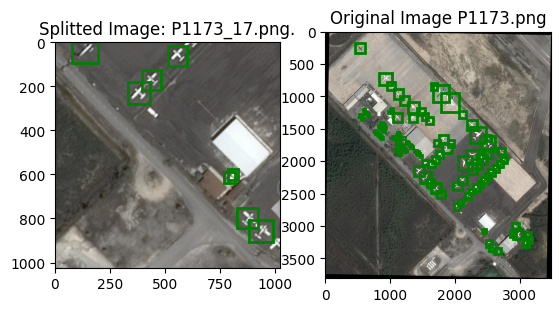

In [17]:
from utils.visualization import plot_org_and_split
print(os.listdir(IMGS_DIR))
plot_org_and_split(
    img_name= "P1173.png",
    DOTA_ROOT = DOTA_ROOT,
    DOTA_PREP_ROOT = USER_PATH / "DATA"/ "SlidingWindow" / DOTA_SET,
    SPLIT = 'train'
)

### Check Class Balance after Preprocessing

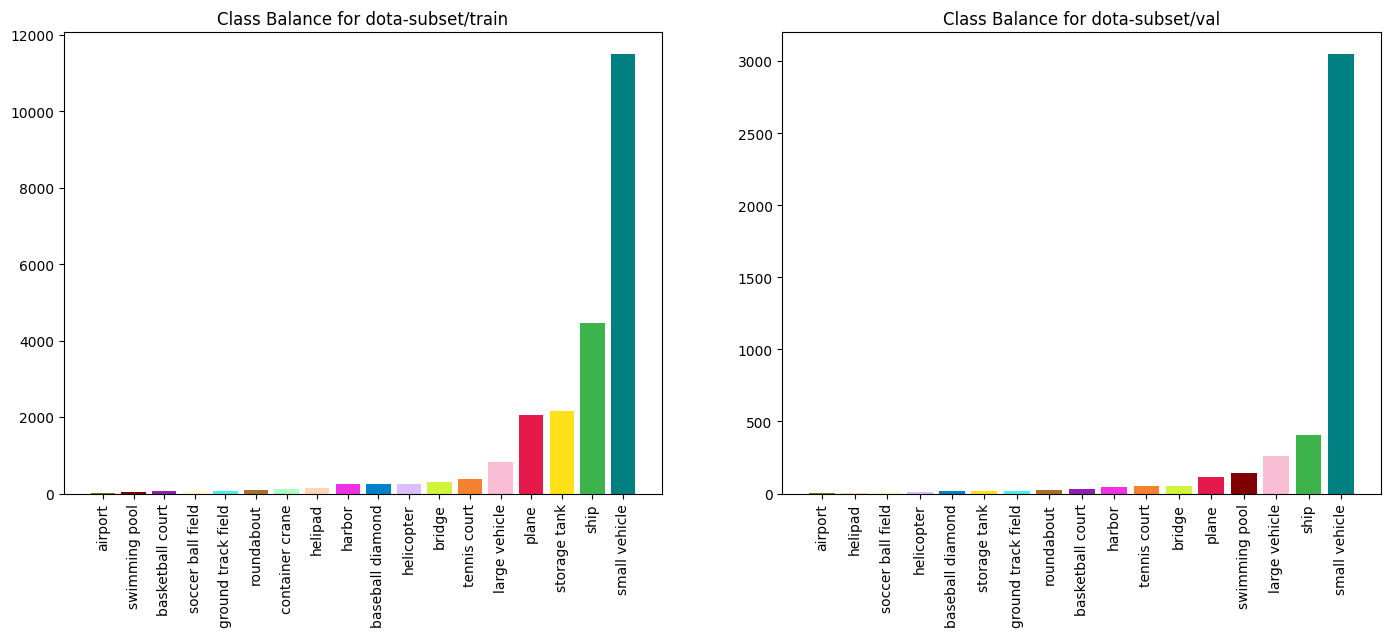

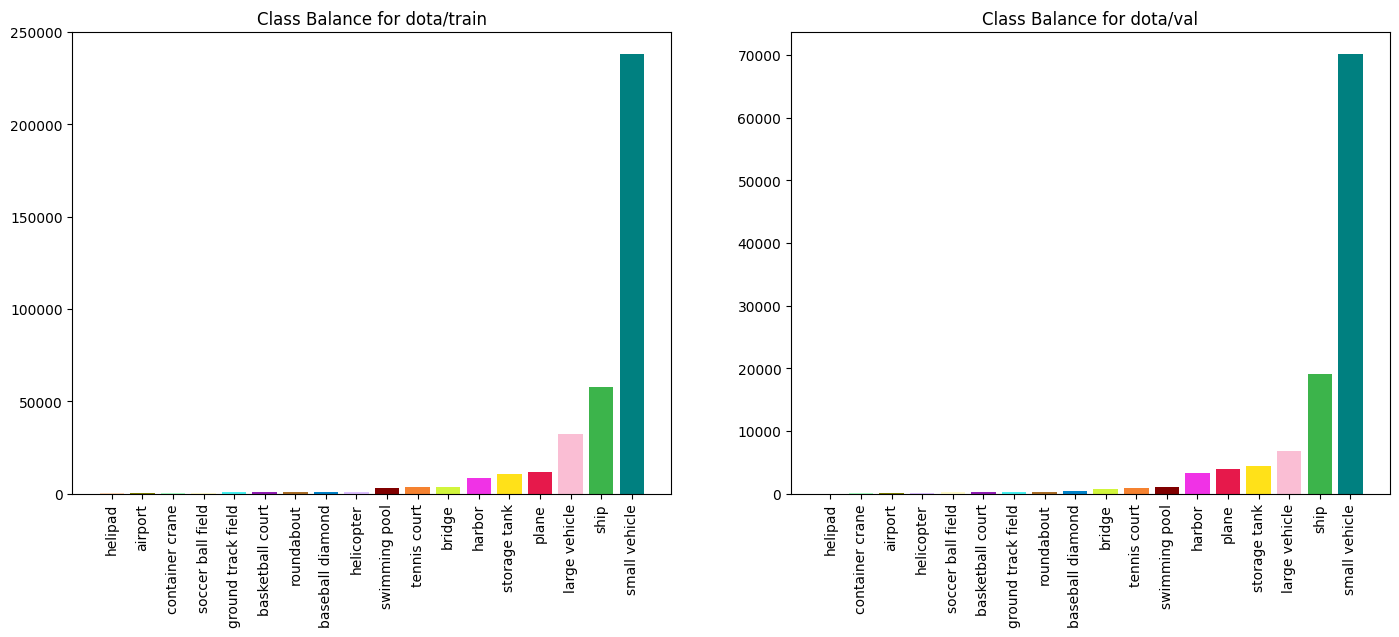

In [1]:
from utils.visualization import plot_class_freq

splits = ['train', 'val']
plot_class_freq(splits, "dota-subset")
plot_class_freq(splits, "dota")

## Solution 2: Dataset class with integrated moving window
In this Dataset class DOTA_DATASET_v2, all original images are taken and cropped in a moving window approach to the size 1024X1024. This is happening in the Dataset class, therefore the loading of the dataset takes some time for bigger datasets. This solution was not further pursuit. Instead the pipeline in `02-DOTA_FasterRCNN.py` focuses on the first solution.

Still, it is a cool solution to avoid preprocessing and input just any RGB picture, which was the initial thought for this approach.

Image [0/65] is being processed...
Image [10/65] is being processed...
Image [20/65] is being processed...
Image [30/65] is being processed...
Image [40/65] is being processed...
Image [50/65] is being processed...
Image [60/65] is being processed...
torch.Size([3, 1024, 1024])
torch.Size([336, 4])
torch.Size([336])


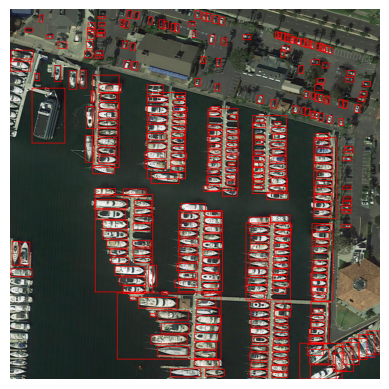

In [18]:
dataset = DOTA_DATASET_v2(csv_file=csv_file, root_img_dir=IMGS_DIR, tile_size=1024, overlap=200)
image, target = dataset[2] 
print(image.shape)  # Should be (3, 1024, 1024)
print(target["boxes"].shape)  # Bounding boxes adjusted for the tile
print(target["labels"].shape)

plot_image_with_boxes(image, target['boxes'])

+++Batch size: 4+++
---Inspecting sample 1 of batch 1---


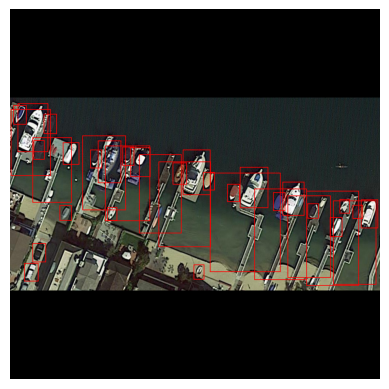

---Inspecting sample 2 of batch 1---


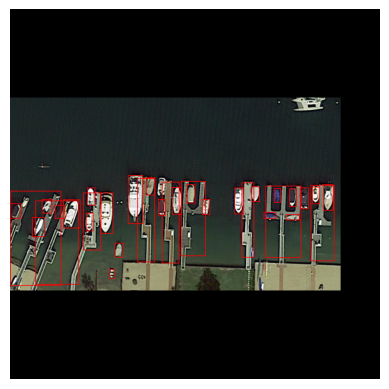

---Inspecting sample 3 of batch 1---


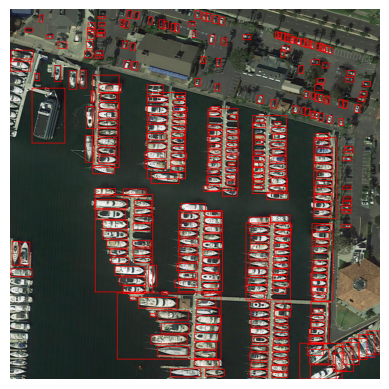

---Inspecting sample 4 of batch 1---


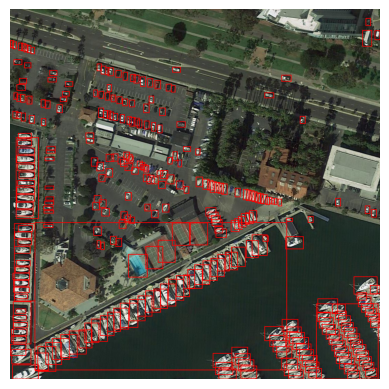

+++Batch size: 4+++
---Inspecting sample 1 of batch 2---


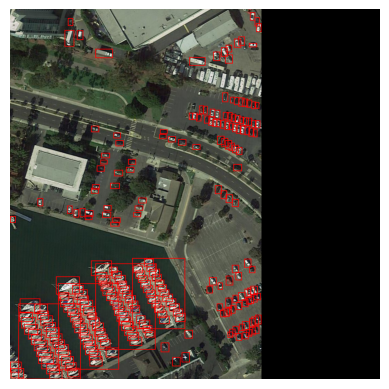

---Inspecting sample 2 of batch 2---


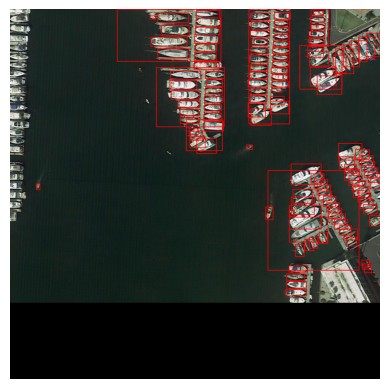

---Inspecting sample 3 of batch 2---


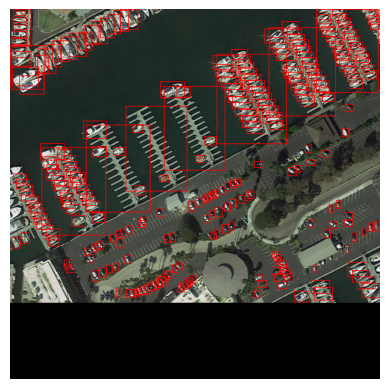

---Inspecting sample 4 of batch 2---


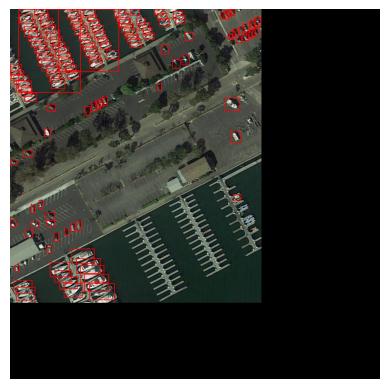

In [19]:
from utils.dataset import collate_fn
    
data_loader = DataLoader(
    dataset,
    batch_size=4,
    collate_fn=collate_fn,
)

for i, (images, targets) in enumerate(data_loader):
    if i == 2: # n batches
        break
    print(f"+++Batch size: {len(images)}+++")
    for j, (img, target) in enumerate(zip(images, targets)):
        print(f"---Inspecting sample {j + 1} of batch {i + 1}---")
        plot_image_with_boxes(
        img, target['boxes'])
